# Southern Ocean Clusters from Seal Data (2008 subset)

In this exploratory notebook, we use unsupervised classification (GMM) on the 2008 seal profiles in order to look for subpopulations in the dataset. 

Input dataset: the 2008 seal data used to constrain B-SOSE

#### Import modules

In [1]:
#import scikit-learn
from sklearn import mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA
# import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib as mpl
# for label map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# pyxpcm, xarray, dask
import numpy as np
import xarray as xr
import dask
import random

#### Install pyxpcm and import pcm [commented out for now]

In [2]:
#!pip install pyxpcm
#from pyxpcm.models import pcm

#### Import profile data from NetCDF

In [3]:
# import example dataset
df = xr.open_dataset('../../datasets_bsose/MEO_SO_2008_MEO_D.nc')

# assign depth coordinate
df.coords['iDEPTH'] = df.depth.values

# select subset of data between 0-1000 dbar
df = df.sel(iDEPTH=slice(5,1000))

# only keep a subset of the variables
df = df.get(['depth','prof_date','prof_YYYYMMDD','prof_HHMMSS',
             'prof_lon','prof_lat','prof_S', 'prof_T'])

# examine df dataframe
df

<xarray.Dataset>
Dimensions:        (iDEPTH: 64, iPROF: 43049)
Coordinates:
  * iDEPTH         (iDEPTH) float64 7.0 10.0 13.0 16.0 ... 900.0 950.0 1e+03
Dimensions without coordinates: iPROF
Data variables:
    depth          (iDEPTH) float64 7.0 10.0 13.0 16.0 ... 900.0 950.0 1e+03
    prof_date      (iPROF) float64 ...
    prof_YYYYMMDD  (iPROF) float64 ...
    prof_HHMMSS    (iPROF) float64 ...
    prof_lon       (iPROF) float64 ...
    prof_lat       (iPROF) float64 ...
    prof_S         (iPROF, iDEPTH) float64 ...
    prof_T         (iPROF, iDEPTH) float64 ...
Attributes:
    description:  Format: MITprof. This file was created using \nthe matlab t...
    date:         11-Aug-2016

#### Plot all temperature profiles

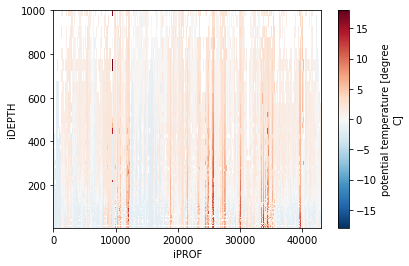

In [4]:
df.prof_T[:,:].plot(y='iDEPTH', yincrease=False, ylim=(5,1000))

#### Plot all salinity profiles

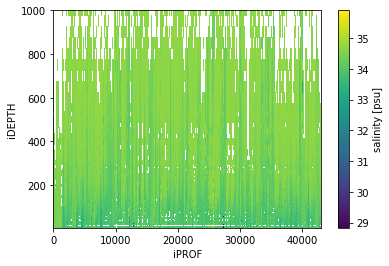

In [5]:
df.prof_S[:,:].plot(y='iDEPTH', yincrease=False, ylim=(5,1000))

#### Discard a few outlier profiles

In [6]:
# clip to get rid of anomalous values
df = df.where(df.prof_S>=33.0)
df = df.where(df.prof_T<=12.0)

#### Interpolate NaN values where possible

In [7]:
# interpolate NaN values in the salinity profiles 
da = df.prof_S
interp_S = da.interpolate_na(dim='iDEPTH',method='linear')
df = df.assign({'interp_S':interp_S})

# interpolate NaN values in the temperature profiles 
da = df.prof_T
interp_T = da.interpolate_na(dim='iDEPTH',method='linear')
df = df.assign({'interp_T':interp_T})

# examine dataframe
df

<xarray.Dataset>
Dimensions:        (iDEPTH: 64, iPROF: 43049)
Coordinates:
  * iDEPTH         (iDEPTH) float64 7.0 10.0 13.0 16.0 ... 900.0 950.0 1e+03
Dimensions without coordinates: iPROF
Data variables:
    depth          (iDEPTH, iPROF) float64 7.0 7.0 7.0 7.0 ... nan nan nan nan
    prof_date      (iPROF, iDEPTH) float64 7.338e+05 7.338e+05 nan ... nan nan
    prof_YYYYMMDD  (iPROF, iDEPTH) float64 2.008e+07 2.008e+07 nan ... nan nan
    prof_HHMMSS    (iPROF, iDEPTH) float64 1.75e+05 1.75e+05 nan ... nan nan nan
    prof_lon       (iPROF, iDEPTH) float64 70.69 70.69 nan 70.69 ... nan nan nan
    prof_lat       (iPROF, iDEPTH) float64 -49.68 -49.68 nan ... nan nan nan
    prof_S         (iPROF, iDEPTH) float64 33.84 33.84 nan 33.85 ... nan nan nan
    prof_T         (iPROF, iDEPTH) float64 3.943 3.939 nan 3.92 ... nan nan nan
    interp_S       (iPROF, iDEPTH) float64 33.84 33.84 33.85 ... nan nan nan
    interp_T       (iPROF, iDEPTH) float64 3.943 3.939 3.929 ... nan nan nan
Attributes:
    description:  Format: MITprof. This file was created using \nthe matlab t...
    date:         11-Aug-2016

#### Plot temperature profiles after NaN interpolation

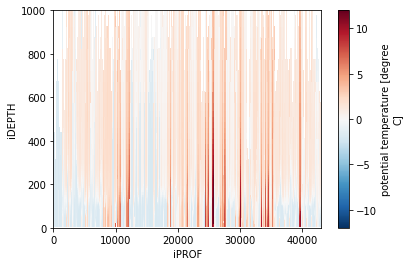

In [8]:
df.interp_T[:,:].plot(y='iDEPTH', yincrease=False, ylim=(0,1000))

#### Calculate mean temperature profile across dataset

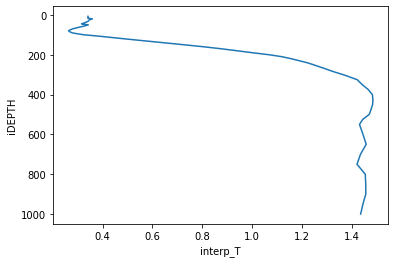

In [9]:
mean_T = df.interp_T.mean(dim='iPROF', skipna=True)
df = df.assign({'mean_T':mean_T})
mean_T.plot(y='iDEPTH', yincrease=False)

#### Plot salinity profiles after NaN interpolation

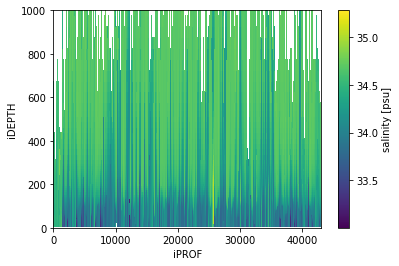

In [10]:
df.interp_S[:,:].plot(y='iDEPTH', ylim=(0,1000), yincrease=False)

#### Calculate mean salinity profile across dataset

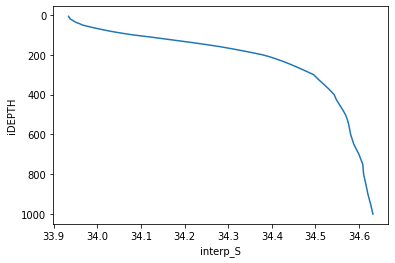

In [11]:
# calculate the mean salinity profile (skip NaN values)
mean_S = df.interp_S.mean(dim='iPROF', skipna=True)

# assign the mean salinity profile to the df dataset
df = df.assign({'mean_S':mean_S})

# plot the whole-dataset mean salinity profile with depth
mean_S.plot(y='iDEPTH', yincrease=False)

In [12]:
df

<xarray.Dataset>
Dimensions:        (iDEPTH: 64, iPROF: 43049)
Coordinates:
  * iDEPTH         (iDEPTH) float64 7.0 10.0 13.0 16.0 ... 900.0 950.0 1e+03
Dimensions without coordinates: iPROF
Data variables:
    depth          (iDEPTH, iPROF) float64 7.0 7.0 7.0 7.0 ... nan nan nan nan
    prof_date      (iPROF, iDEPTH) float64 7.338e+05 7.338e+05 nan ... nan nan
    prof_YYYYMMDD  (iPROF, iDEPTH) float64 2.008e+07 2.008e+07 nan ... nan nan
    prof_HHMMSS    (iPROF, iDEPTH) float64 1.75e+05 1.75e+05 nan ... nan nan nan
    prof_lon       (iPROF, iDEPTH) float64 70.69 70.69 nan 70.69 ... nan nan nan
    prof_lat       (iPROF, iDEPTH) float64 -49.68 -49.68 nan ... nan nan nan
    prof_S         (iPROF, iDEPTH) float64 33.84 33.84 nan 33.85 ... nan nan nan
    prof_T         (iPROF, iDEPTH) float64 3.943 3.939 nan 3.92 ... nan nan nan
    interp_S       (iPROF, iDEPTH) float64 33.84 33.84 33.85 ... nan nan nan
    interp_T       (iPROF, iDEPTH) float64 3.943 3.939 3.929 ... nan nan nan
    mean_T         (iDEPTH) float64 0.3408 0.3407 0.3403 ... 1.457 1.446 1.436
    mean_S         (iDEPTH) float64 33.93 33.93 33.94 ... 34.62 34.63 34.63
Attributes:
    description:  Format: MITprof. This file was created using \nthe matlab t...
    date:         11-Aug-2016

#### Replace remaining missing values with mean profile values, plot the results

In [13]:
# replace remaining missing values with mean profile : temp
da = df.interp_T
clean_T = da.fillna(df.mean_T)
#clean_T = da.where(lambda da: da.notnull(), df.mean_T)
df = df.assign({'clean_T':clean_T})

# replace remaining missing values with mean profile : salt
da = df.interp_S
clean_S = da.fillna(df.mean_S)
#clean_S = da.where(lambda da: da.notnull(), df.mean_S)
df = df.assign({'clean_S':clean_S})

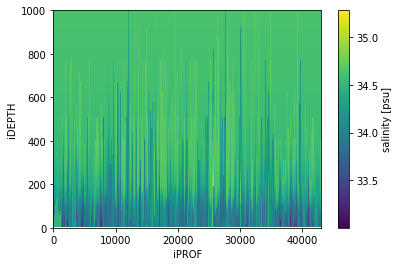

In [14]:
df.clean_S[:,:].plot(y='iDEPTH', ylim=(0,1000), yincrease=False)

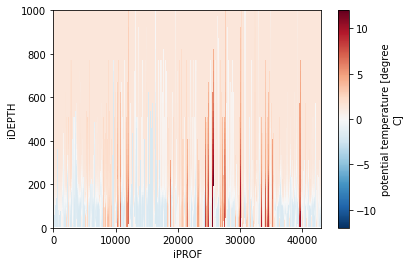

In [15]:
df.clean_T[:,:].plot(y='iDEPTH', ylim=(0,1000), yincrease=False)

## Clustering attempt with scikit-learn GMM

#### Preprocess data variables

In [16]:
# scale salinity
X = df.clean_S
scaled_S = preprocessing.scale(X)
scaled_S.shape

# scale temperature
X = df.clean_T
scaled_T = preprocessing.scale(X)
scaled_T.shape

# concatenate 
Xscaled = np.concatenate((scaled_T,scaled_S),axis=1)

# create PCA object
pca = PCA(n_components=18)

# fit PCA model
pca.fit(Xscaled)

# transform input data into PCA representation
Xpca = pca.transform(Xscaled)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9774923133340425

#### Calculate BIC scores for a range of BIC values

In [17]:
# select parameters
max_N = 20     # the maximum number of classes to try 
max_bic_iter = 20  # the maximum number of iterations for BIC

# for the BIC step, try using a subset of the profiles
# you can change this 1000 value for different subsets
#Xpca_for_BIC = Xpca[::1000]

# initialise, declare variables
lowest_bic = np.infty
bic_scores = np.zeros((2,max_bic_iter))

# loop through the maximum number of classes, estimate BIC
n_components_range = range(2, max_N)
bic_iter_range = range(0,max_bic_iter)
# iterate through all the covariance types (just 'full' for now)
cv_types = ['full']
for cv_type in cv_types:
    # iterate over all the possible numbers of components
    for n_components in n_components_range:
        bic_one = []
        # repeat the BIC step for better statistics
        for bic_iter in bic_iter_range:
            # select a new random subset
            rows_id = random.sample(range(0,Xpca.shape[0]-1), 1000)
            Xpca_for_BIC = Xpca[rows_id,:]
            # fit a Gaussian mixture model
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type,
                                          random_state=42)

            # uncomment for 'rapid' BIC fitting
            gmm.fit(Xpca_for_BIC)
            # uncomment for 'full' BIC fitting
            #gmm.fit(Xpca)

            # append this BIC score to the list
            bic_one.append(gmm.bic(Xpca_for_BIC))
            Xpca_for_BIC = []

        # stack the bic scores into a single 2D structure
        bic_scores = np.vstack((bic_scores, np.asarray(bic_one)))

# the first two rows are not needed; they were only placeholders
bic_scores = bic_scores[2:,:]

# mean values for BIC
bic_mean = np.mean(bic_scores, axis=1)

# standard deviation for BIC
bic_std = np.std(bic_scores, axis=1)

# examine the mean bic values
#bic_mean

#### Plot BIC scores 

Text(0, 0.5, 'BIC score')

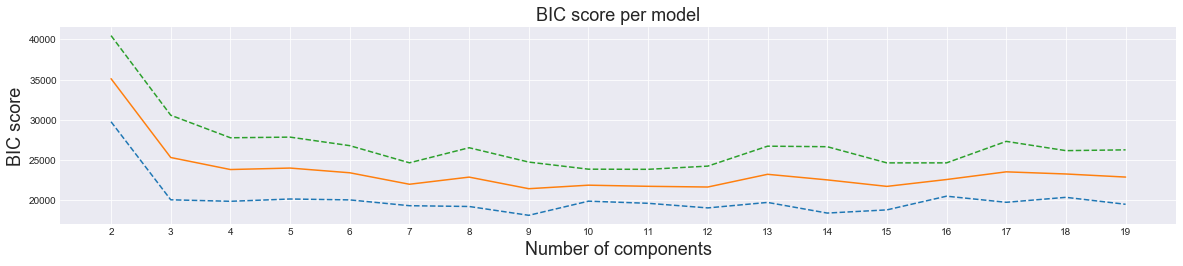

In [18]:
# plot the BIC scores
plt.figure(figsize=(20, 8))
plt.style.use('seaborn-darkgrid')
spl = plt.subplot(2, 1, 1)
plt.plot(n_components_range, bic_mean-bic_std, '--')  
plt.plot(n_components_range, bic_mean, '-')  
plt.plot(n_components_range, bic_mean+bic_std, '--')  
plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model', fontsize=18)
spl.set_xlabel('Number of components',fontsize=18)
spl.set_ylabel('BIC score',fontsize=18)
#plt.show()

#### GMM

In [19]:
# set variables
n_components_selected = 6

# establish gmm
best_gmm = mixture.GaussianMixture(n_components=n_components_selected,
                                   covariance_type='full',
                                   random_state=42)

# fit this GMM
best_gmm.fit(Xpca)

# check to make sure that n_comp is as expected
n_comp = gmm.n_components

# select colormap
colormap = plt.get_cmap('tab10', n_comp)

# assign class labels ("predict" the class using the selected GMM)
labels = best_gmm.predict(Xpca)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs = best_gmm.predict_proba(Xpca)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs = np.max(posterior_probs,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
#df.insert(3,'label',labels,True)
#df.insert(4,'max posterior prob',max_posterior_probs,True) 

# print out best_gmm parameters
posterior_probs.shape

(43049, 6)

In [20]:
# convert labels into xarray format
xlabels = xr.DataArray(labels, coords=[df.iPROF], dims='iPROF')

# convert posterior probabilities into xarray format
gmm_classes = [b for b in range(0,n_components_selected,1)]
xprobs = xr.DataArray(posterior_probs, 
                      coords=[df.iPROF, gmm_classes], 
                      dims=['iPROF', 'CLASS'])

# add label DataArray to Dataset
df = df.assign({'label':xlabels})
df = df.assign({'posteriors':xprobs})

In [21]:
df

<xarray.Dataset>
Dimensions:        (CLASS: 6, iDEPTH: 64, iPROF: 43049)
Coordinates:
  * iPROF          (iPROF) int64 0 1 2 3 4 5 ... 43044 43045 43046 43047 43048
  * iDEPTH         (iDEPTH) float64 7.0 10.0 13.0 16.0 ... 900.0 950.0 1e+03
  * CLASS          (CLASS) int64 0 1 2 3 4 5
Data variables:
    depth          (iDEPTH, iPROF) float64 7.0 7.0 7.0 7.0 ... nan nan nan nan
    prof_date      (iPROF, iDEPTH) float64 7.338e+05 7.338e+05 nan ... nan nan
    prof_YYYYMMDD  (iPROF, iDEPTH) float64 2.008e+07 2.008e+07 nan ... nan nan
    prof_HHMMSS    (iPROF, iDEPTH) float64 1.75e+05 1.75e+05 nan ... nan nan nan
    prof_lon       (iPROF, iDEPTH) float64 70.69 70.69 nan 70.69 ... nan nan nan
    prof_lat       (iPROF, iDEPTH) float64 -49.68 -49.68 nan ... nan nan nan
    prof_S         (iPROF, iDEPTH) float64 33.84 33.84 nan 33.85 ... nan nan nan
    prof_T         (iPROF, iDEPTH) float64 3.943 3.939 nan 3.92 ... nan nan nan
    interp_S       (iPROF, iDEPTH) float64 33.84 33.84 33.85 ... nan nan nan
    interp_T       (iPROF, iDEPTH) float64 3.943 3.939 3.929 ... nan nan nan
    mean_T         (iDEPTH) float64 0.3408 0.3407 0.3403 ... 1.457 1.446 1.436
    mean_S         (iDEPTH) float64 33.93 33.93 33.94 ... 34.62 34.63 34.63
    clean_T        (iPROF, iDEPTH) float64 3.943 3.939 3.929 ... 1.446 1.436
    clean_S        (iPROF, iDEPTH) float64 33.84 33.84 33.85 ... 34.63 34.63
    label          (iPROF) int64 3 1 1 3 1 1 3 3 1 2 3 ... 3 3 3 3 1 5 3 3 3 1 3
    posteriors     (iPROF, CLASS) float64 6.951e-22 4.601e-11 ... 1.656e-08
Attributes:
    description:  Format: MITprof. This file was created using \nthe matlab t...
    date:         11-Aug-2016

#### Calculate class properties using groupby function

In [22]:
# create grouped object using the labels
grouped = df.groupby("label")

# class means and standard deviations
class_means = grouped.mean()
class_stds = grouped.std()

# visualize grouped dataset
class_means

<xarray.Dataset>
Dimensions:        (CLASS: 6, iDEPTH: 64, label: 6)
Coordinates:
  * iDEPTH         (iDEPTH) float64 7.0 10.0 13.0 16.0 ... 900.0 950.0 1e+03
  * label          (label) int64 0 1 2 3 4 5
  * CLASS          (CLASS) int64 0 1 2 3 4 5
Data variables:
    depth          (label, iDEPTH) float64 7.0 10.0 13.0 16.0 ... nan nan nan
    prof_date      (label, iDEPTH) float64 7.336e+05 7.336e+05 ... nan nan
    prof_YYYYMMDD  (label, iDEPTH) float64 2.008e+07 2.008e+07 ... nan nan
    prof_HHMMSS    (label, iDEPTH) float64 1.178e+05 1.178e+05 ... nan nan
    prof_lon       (label, iDEPTH) float64 171.8 171.8 153.4 ... nan nan nan
    prof_lat       (label, iDEPTH) float64 -61.58 -61.58 -66.91 ... nan nan nan
    prof_S         (label, iDEPTH) float64 34.04 34.04 34.46 ... nan nan nan
    prof_T         (label, iDEPTH) float64 -1.049 -1.048 -1.768 ... nan nan nan
    interp_S       (label, iDEPTH) float64 34.04 34.04 34.04 ... nan nan nan
    interp_T       (label, iDEPTH) float64 -1.049 -1.048 -1.049 ... nan nan nan
    mean_T         (label, iDEPTH) float64 0.3408 0.3407 0.3403 ... 1.446 1.436
    mean_S         (label, iDEPTH) float64 33.93 33.93 33.94 ... 34.63 34.63
    clean_T        (label, iDEPTH) float64 -0.4374 -0.4372 ... 1.446 1.436
    clean_S        (label, iDEPTH) float64 33.99 33.99 34.0 ... 34.63 34.63
    posteriors     (label, CLASS) float64 0.9917 2.436e-05 ... 0.001103 0.9782

#### Plot temperature properties of the classes

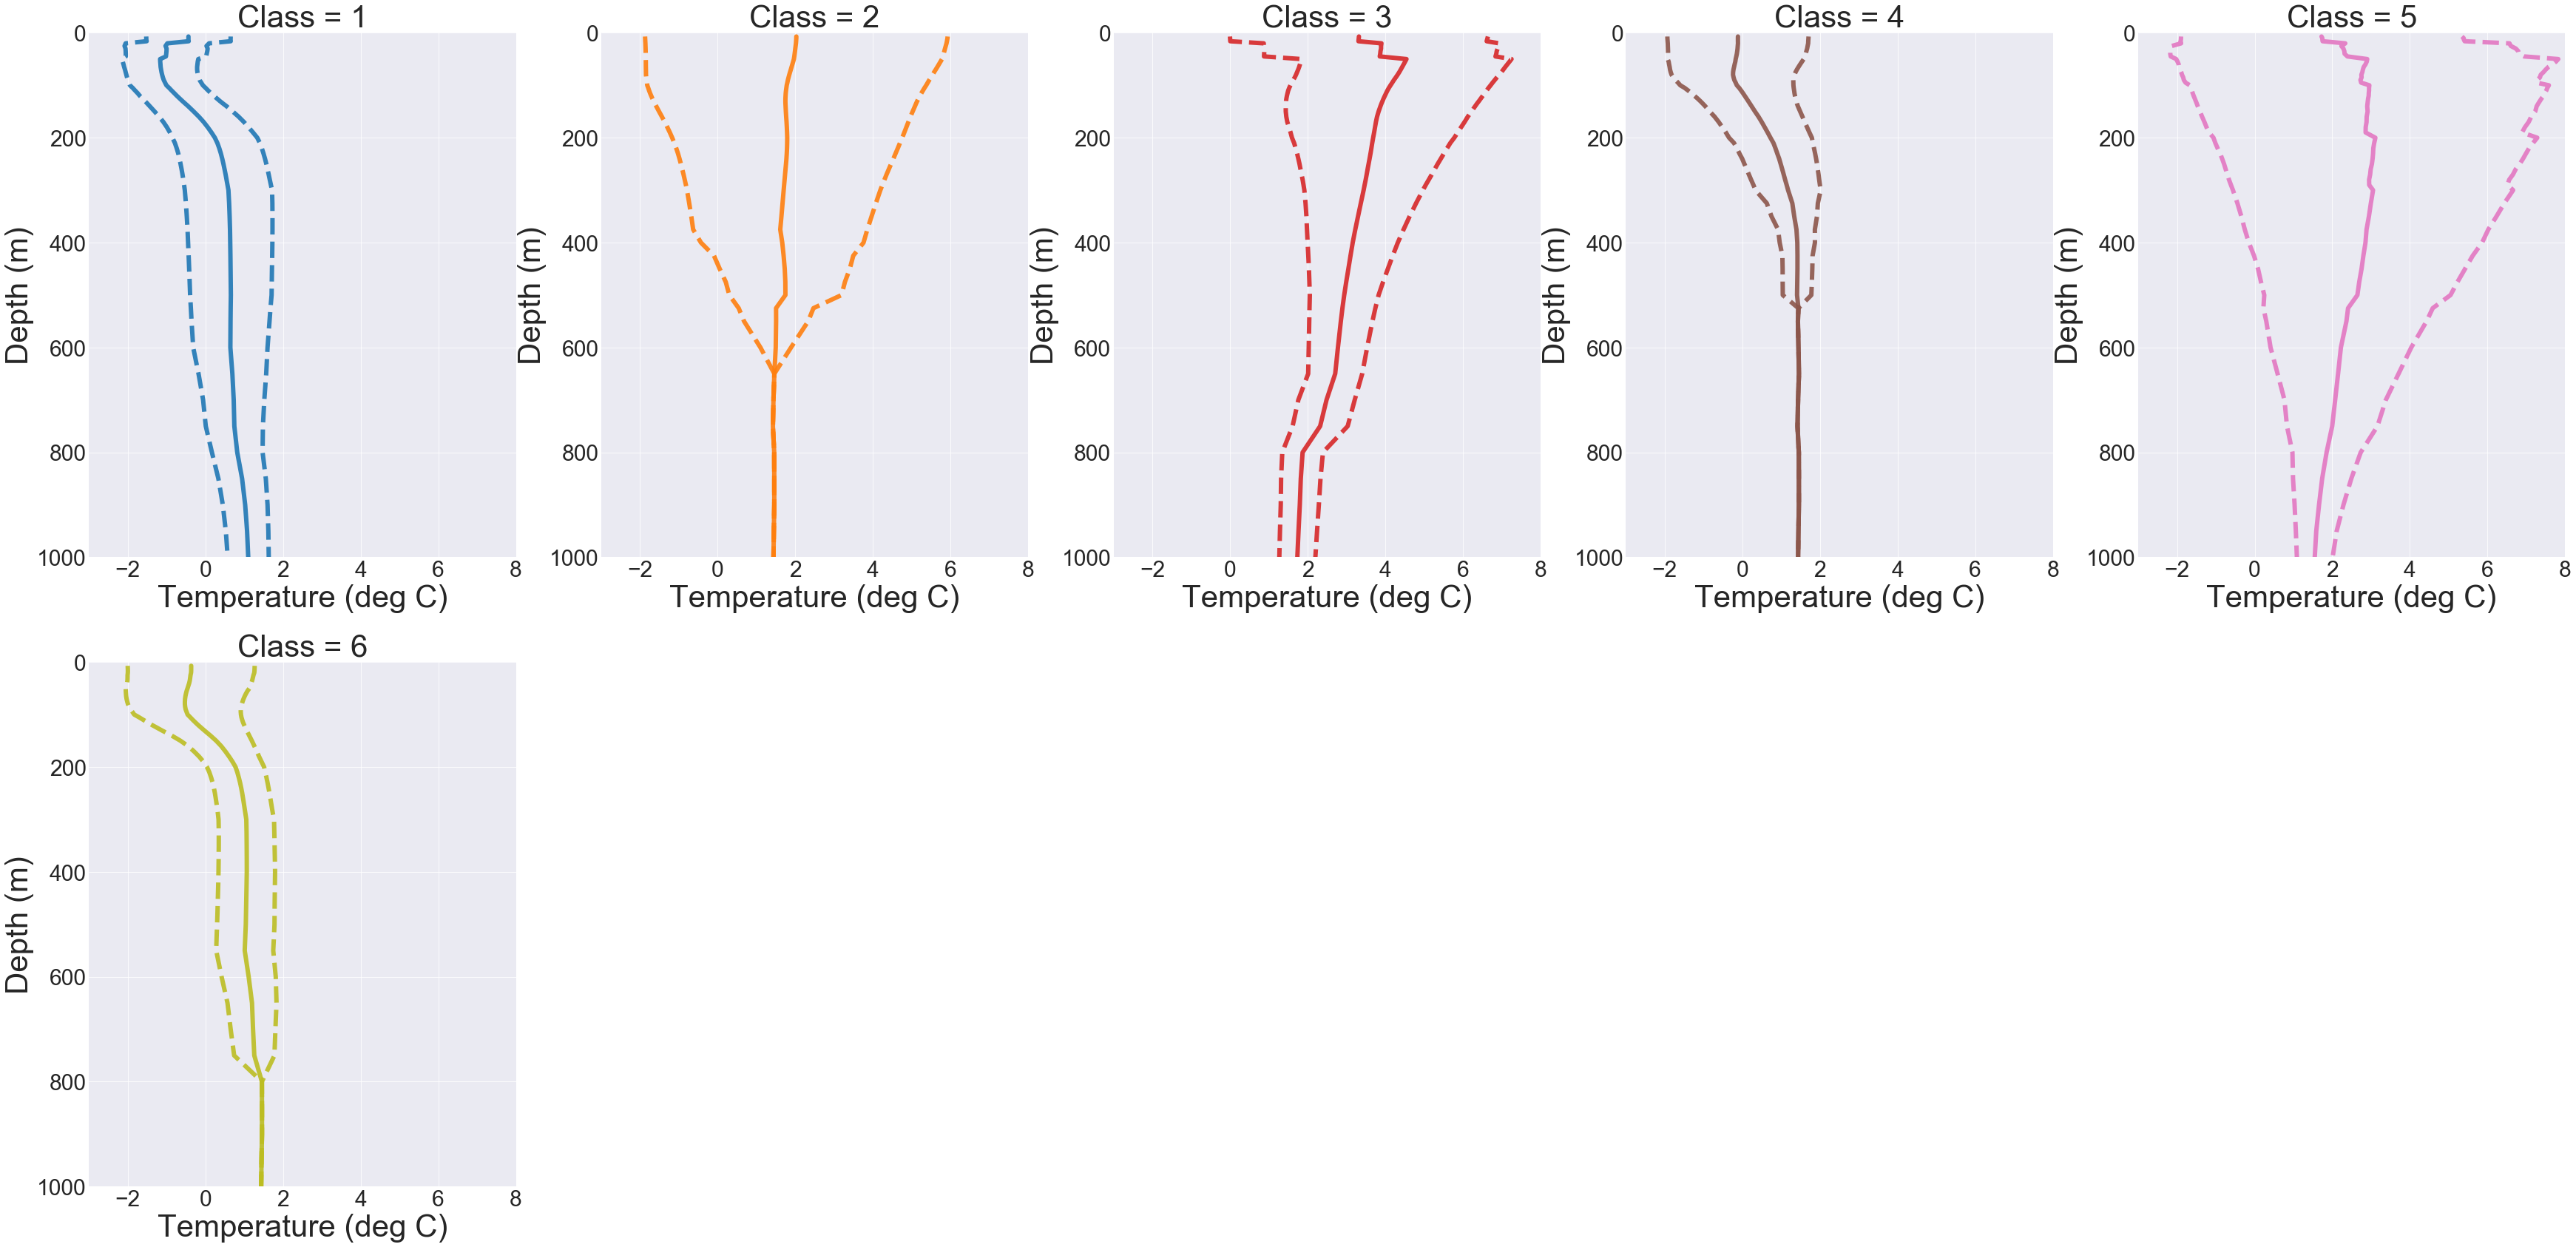

In [23]:
cNorm = colors.Normalize(vmin=0, vmax=n_components_selected)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# vertical coordinate
z = df.iDEPTH.values    
    
# iterate over groups
num = 0
for nrow in range(0,n_components_selected):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
    
    # extract means
    mean_T = class_means.clean_T[nrow,:].values
    
    # extract stdevs
    std_T = class_stds.clean_T[nrow,:].values
    
    # select subplot
    ax = plt.subplot(np.ceil(n_comp/5),5,num)
    plt.plot(mean_T, z, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T+std_T, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T-std_T, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([0,1000])
    plt.xlim([-3, 8])
    
   #text box
    fs = 42 # font size
    plt.xlabel('Temperature (deg C)', fontsize=fs)
    plt.ylabel('Depth (m)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)

   

#### Plot the salinity properties of the classes

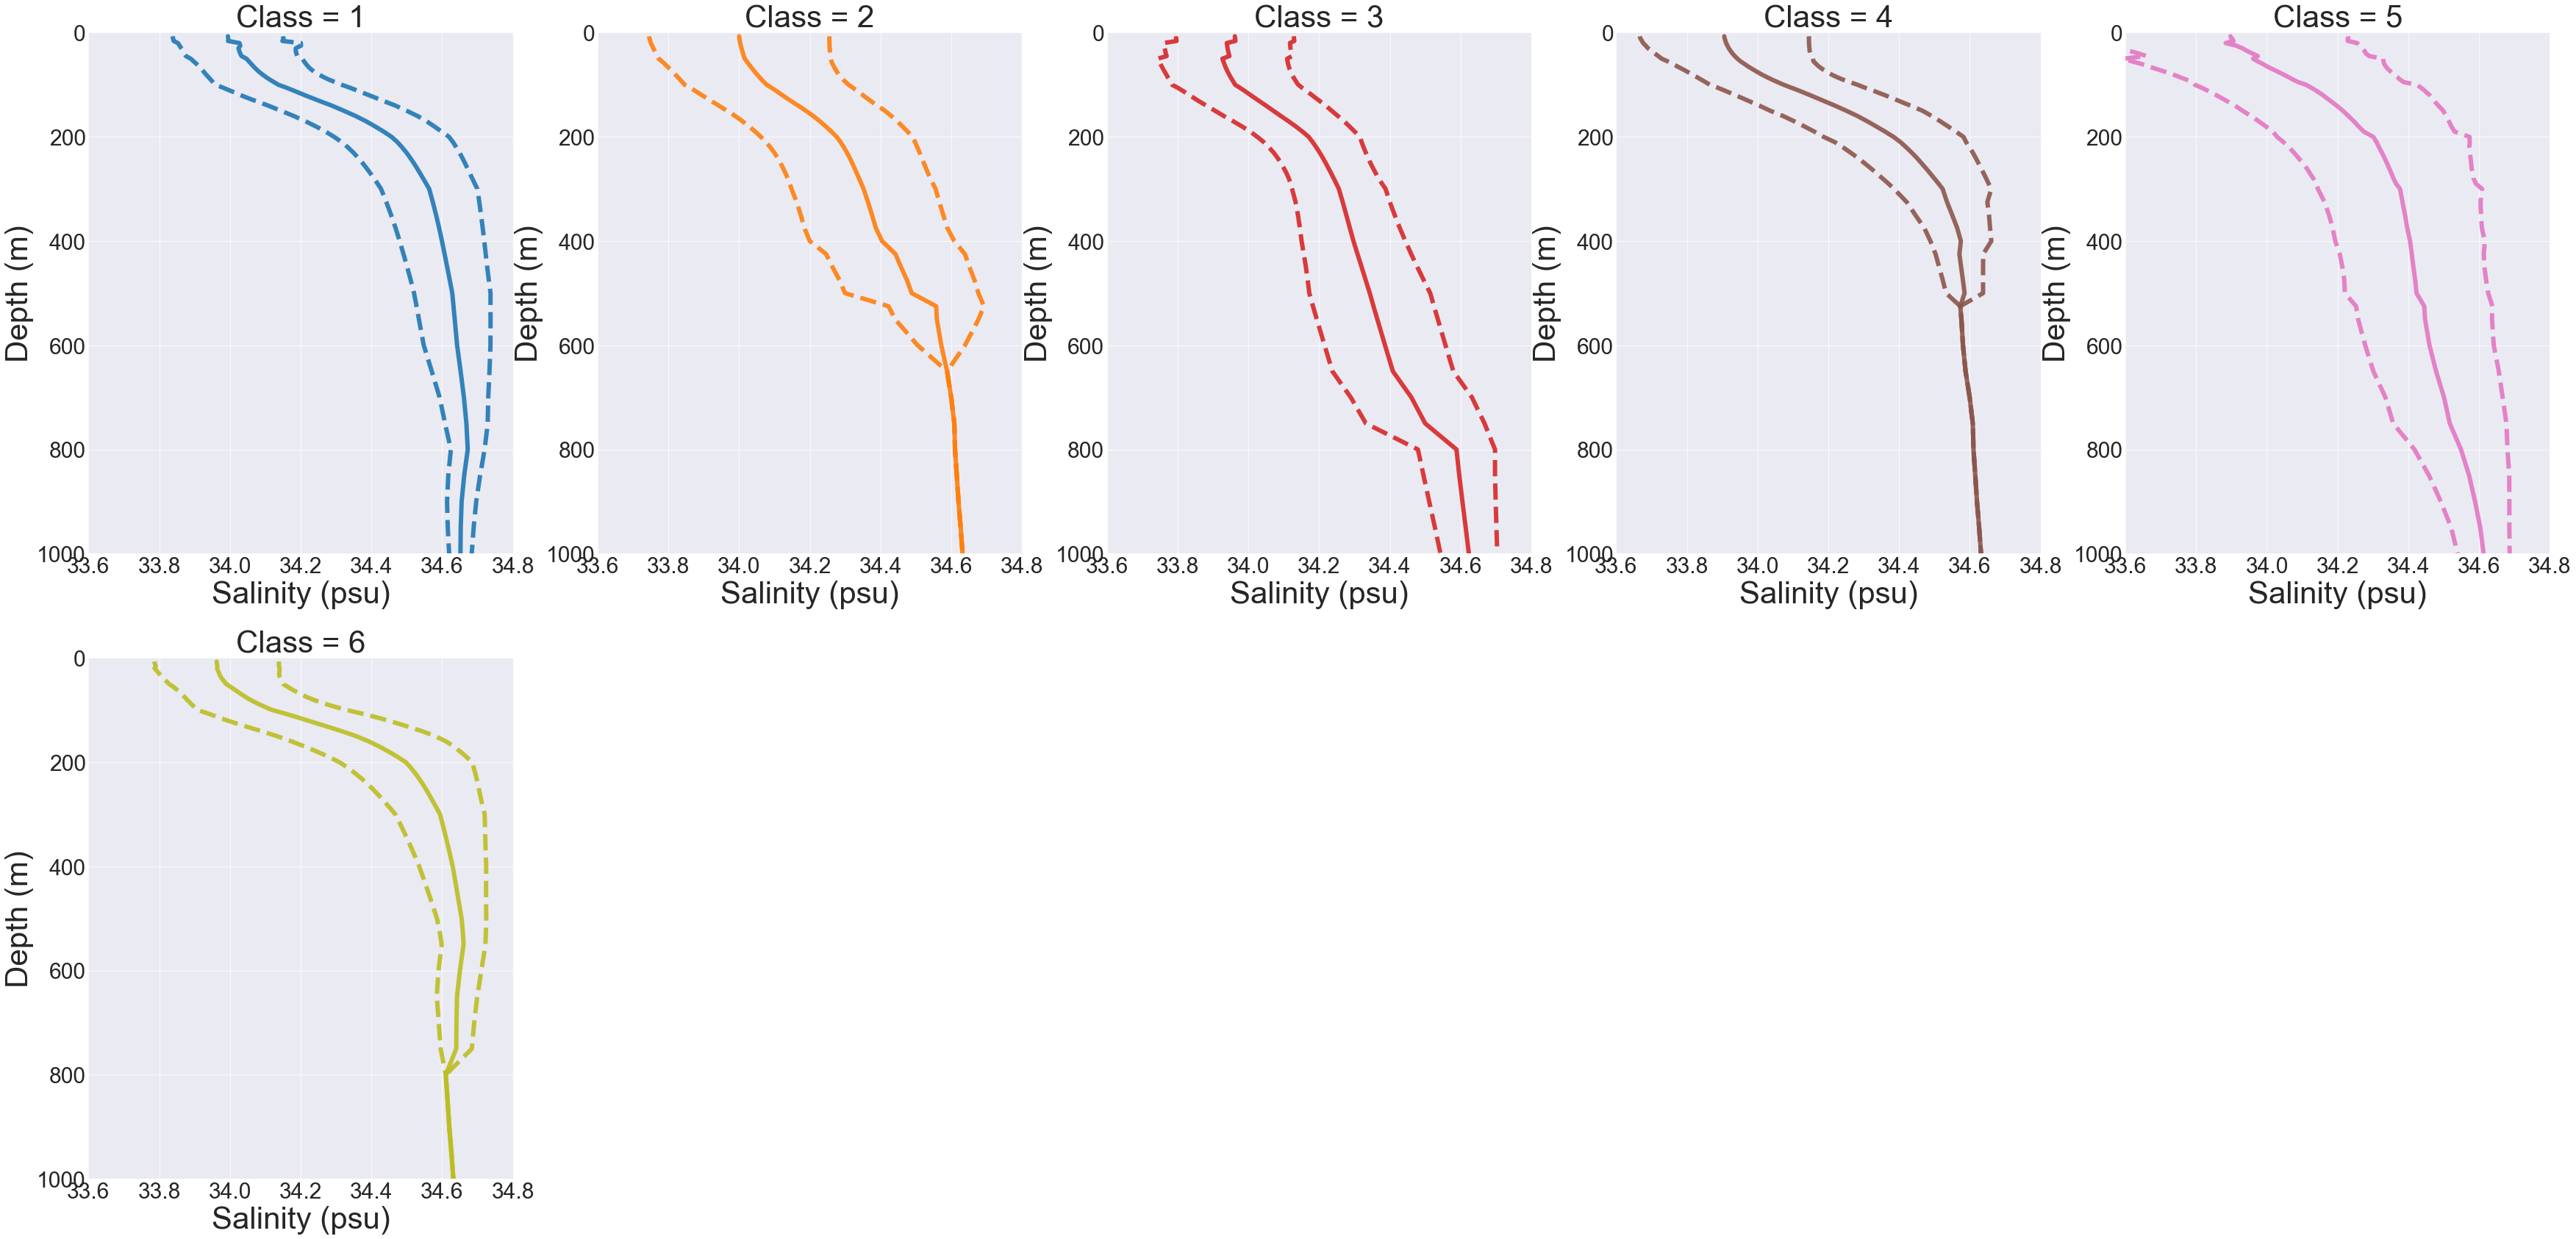

In [24]:
cNorm = colors.Normalize(vmin=0, vmax=n_components_selected)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# vertical coordinate
z = df.iDEPTH.values    
    
# iterate over groups
num = 0
for nrow in range(0,n_components_selected):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
    
    # extract means
    mean_S = class_means.clean_S[nrow,:].values
    
    # extract stdevs
    std_S = class_stds.clean_S[nrow,:].values
    
    # select subplot
    ax = plt.subplot(np.ceil(n_comp/5),5,num)
    plt.plot(mean_S, z, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_S+std_S, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_S-std_S, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([0,1000])
    plt.xlim([33.6, 34.8])
    
   #text box
    fs = 42 # font size
    plt.xlabel('Salinity (psu)', fontsize=fs)
    plt.ylabel('Depth (m)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
   

#### Label map

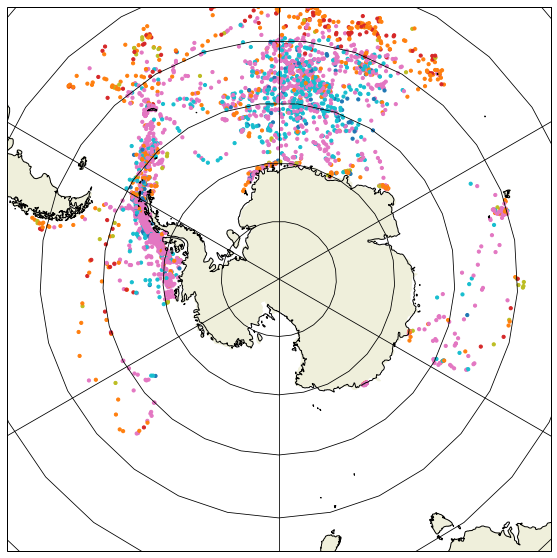

In [25]:
# extract values as new DataArrays
df1D = df.isel(iDEPTH=0)
da_lon = df1D.prof_lon
da_lat = df1D.prof_lat
da_label = df1D.label

# extract values
lons = da_lon.values
lats = da_lat.values
clabels = da_label.values

# random sample for plotting
rows_id = random.sample(range(0,clabels.size-1), 4000)
lons_random_sample = lons[rows_id]
lats_random_sample = lats[rows_id]
clabels_random_sample = clabels[rows_id]

#colormap with Historical data
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
CS = plt.scatter(lons_random_sample-360, 
                 lats_random_sample, 
                 c=clabels_random_sample,
                 marker='o',
                 cmap= colormap,
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

#### Plot maps for each label to see where the profile types are

Text(0.5, 1.0, 'Class 1')

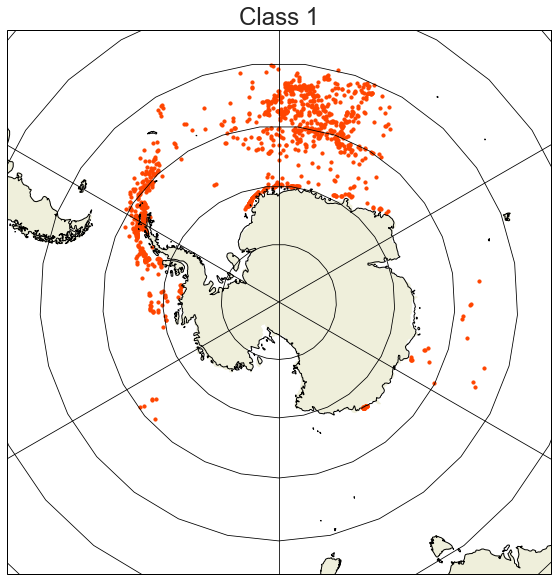

In [26]:
# extract lats lons
lats = da_lat[da_label==0]
lons = da_lon[da_label==0]

#colormap with Historical data
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
CS = plt.scatter(lons-360, 
                 lats, 
                 color="orangered",
                 marker='o',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)
plt.title('Class 1',fontsize=24)


Text(0.5, 1.0, 'Class 2')

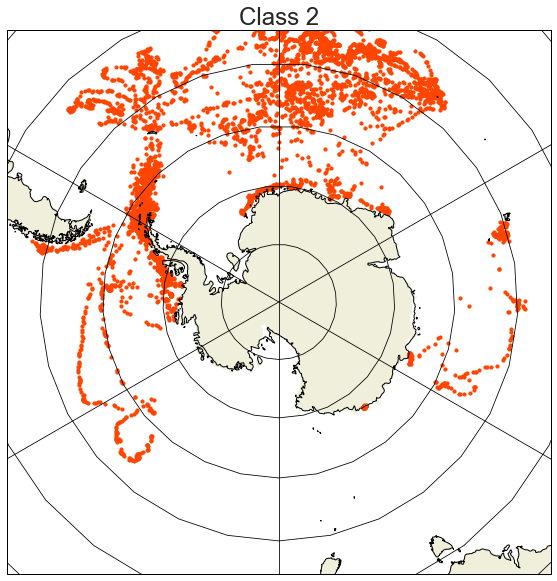

In [27]:
# extract lats lons
lats = da_lat[da_label==1]
lons = da_lon[da_label==1]

#colormap with Historical data
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
CS = plt.scatter(lons-360, 
                 lats, 
                 color="orangered",
                 marker='o',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)
plt.title('Class 2',fontsize=24)

Text(0.5, 1.0, 'Class 3')

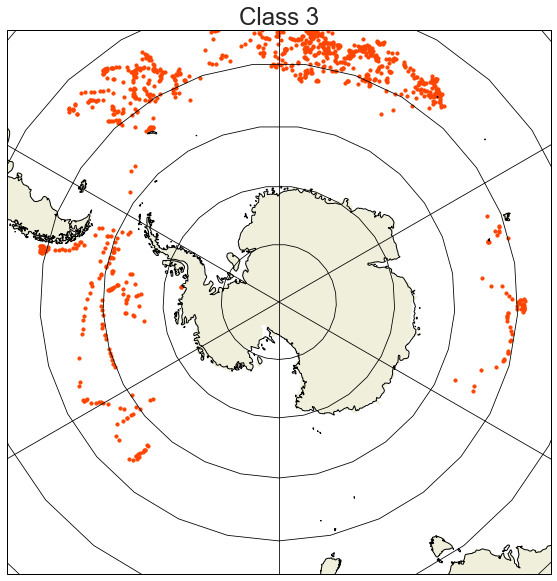

In [28]:
# extract lats lons
lats = da_lat[da_label==2]
lons = da_lon[da_label==2]

#colormap with Historical data
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
CS = plt.scatter(lons-360, 
                 lats, 
                 color="orangered",
                 marker='o',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)
plt.title('Class 3',fontsize=24)

Text(0.5, 1.0, 'Class 4')

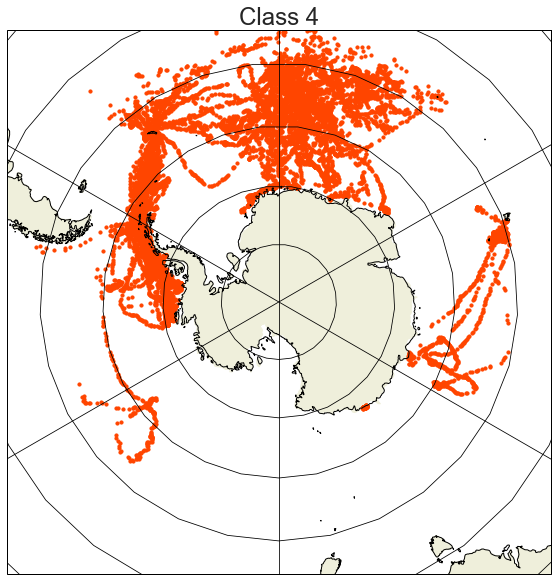

In [29]:
# extract lats lons
lats = da_lat[da_label==3]
lons = da_lon[da_label==3]

#colormap with Historical data
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
CS = plt.scatter(lons-360, 
                 lats, 
                 color="orangered",
                 marker='o',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)
plt.title('Class 4',fontsize=24)

Text(0.5, 1.0, 'Class 5')

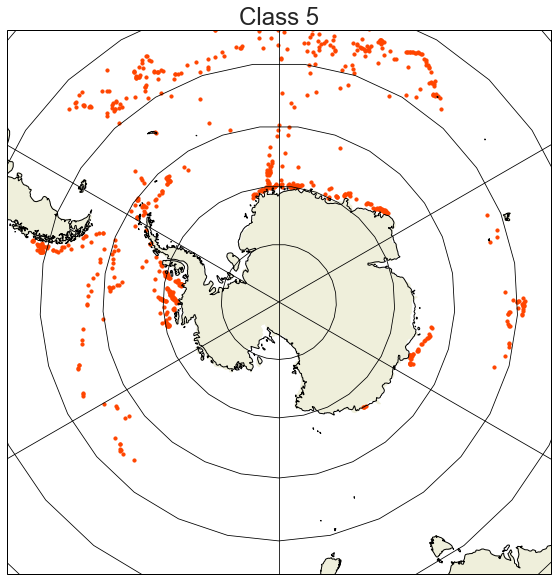

In [30]:
# extract lats lons
lats = da_lat[da_label==4]
lons = da_lon[da_label==4]

#colormap with Historical data
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
CS = plt.scatter(lons-360, 
                 lats, 
                 color="orangered",
                 marker='o',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)
plt.title('Class 5',fontsize=24)

Text(0.5, 1.0, 'Class 6')

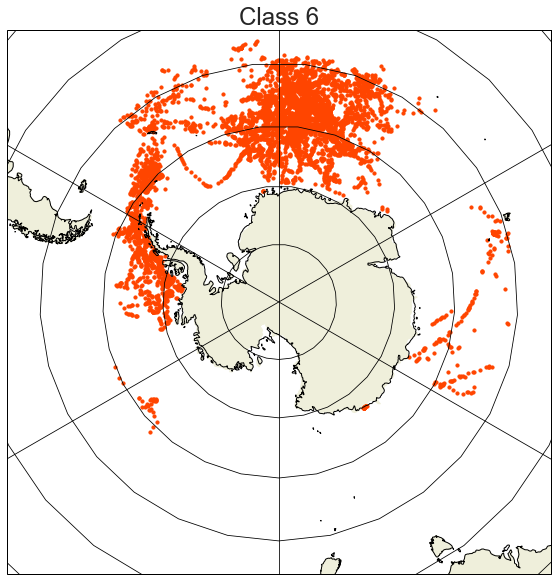

In [35]:
# extract lats lons
lats = da_lat[da_label==5]
lons = da_lon[da_label==5]

#colormap with Historical data
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
CS = plt.scatter(lons-360, 
                 lats, 
                 color="orangered",
                 marker='o',
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)
plt.title('Class 6',fontsize=24)

## Attempt with PCM [no luck yet - errors]

#### Define the parameters for the PCM

In [31]:
# vertical coordinate must be negative
#df['iDEPTH'] = -1.0*df['iDEPTH']

# define vertical coordinate
#z = df.depth.values

# define features and associated vertical coordinate
#pcm_features = {'temperature': z, 'salinity': z}


In [32]:
# define PCM with K classes and defined features
#m = pcm(K=8, features=pcm_features)
#m

In [33]:
# describe features and vertical coordinate
#features_in_df = {'temperature': 'clean_T', 'salinity': 'clean_S'}
#features_zdim='iDEPTH'

#m.fit(df, features=features_in_df, dim=features_zdim)
#m

In [34]:
#df